# Sea Level: Tidal Data 
Notebook for analysing tide measurement data for 1505 tide gauges worldwide. I use the Revised Local Reference (RLR) data set from Permanent Service of Mean Sea Level . The RLR datum is set to 7000 mm below mean sea level therefore the values are all in the range of 6000 to 8000 mm.

All UK tide gauge data is included in the PSMSL data set, most of the data from the University of Hawaii is included as well.

Data source is Permanent Service of Mean Sea Level (http://www.psmsl.org/data/obtaining/complete.php, RLR monthly)

Data set with monthly mean data.

Data has been obtained on 4 November 2017.

## Load libraries

In [1]:
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
from datetime import datetime

import glob
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import json
import matplotlib.pyplot as plt

InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_rows = 200
#matplotlib.rcParams['svg.fonttype'] = 'none'


## Setup the data
### First: Read meta data for all stations of PSMSL

In [3]:
#parse errorflags
stations_errorflag = 'data/psmsl_data/filelist.txt'

errors = pd.read_csv(stations_errorflag, sep=';', header=None, usecols=[0, 6], names=['id', 'latitude', 'longitude', 'locataion', 'coastline', 'station', 'flag' ])

#parse meta data
meta_info = 'data/metadata_psmsl.csv'

stations = pd.read_csv(meta_info, header=0, names=['location', 'ID', 'latitude', 'longitude', 'gloss id', 'country', 'date', 'coastline', 'station'])

#comibe meta data and error flags
stations = stations.merge(errors, left_on='ID', right_on='id')

stations = stations.drop('ID', 1)

len(errors)
len(stations)

stations.head()

1505

1505

,location,latitude,longitude,gloss id,country,date,coastline,station,id,flag
0,REYKJAVIK,64.151,-21.940,229.0,ISL,24/01/2017,10,1,638,N
1,GRINDAVIK,63.833,-22.433,NaN,ISL,01/01/1980,10,11,877,N
2,TORSHAVN,62.017,-6.767,237.0,FRO,30/10/2007,15,11,839,N
3,BARENTSBURG,78.067,14.250,231.0,SJM,17/01/2017,25,1,541,N
4,BARENTSBURG II (SPITSBERGEN),78.067,14.250,231.0,SJM,17/01/2003,25,2,547,N


In [4]:
#convert capitals to lowercase with a capitalized first letter
def convert_location_names(str):
    conversion = str.title()
    return conversion

stations['location'] = stations['location'].apply(convert_location_names)


### Second: Read all the tide data from folder

In [8]:
#parse file

def parse_tides(filename):
    filepath = 'data/psmsl_data/' + str(filename) + '.rlrdata'
    df = pd.read_csv(filepath, sep=';', header=None, names=['year-month', 'tide', 'missing day', 'flag for attention'])

    df['flag for attention'] = df['flag for attention'].apply(lambda x: '{0:0>3}'.format(x))
    df['year'] = df['year-month'].apply(np.floor).astype('int')
    df['month'] = ((((df['year-month'] - df['year'])*24)+1)/2).apply(np.around).astype('int')
    df['day'] = 1 #due the monthly averages, no days are present, set days to 1
    df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day']], errors='coerce')
    df['ID'] = filename
    df['ID'] = df['ID'].astype('int')

    df = df.drop('year-month', 1)
    df = df.drop('year', 1)
    df = df.drop('month', 1)
    df = df.drop('day', 1)
    
    #print (filepath)
    
    return df

#filepath for complete tide data set
filepath = 'data/psmsl_data/tideData_psmsl_complete.csv'

if os.path.exists(filepath):
    df = pd.read_csv(filepath, usecols=[1,2,3,4,5])
    df['flag for attention'] = df['flag for attention'].apply(lambda x: '{0:0>3}'.format(x))
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
else:
    df = pd.concat([parse_tides(f) for f in stations['id']])
    #replace null values
    df['tide'] = df['tide'].replace(-99999,np.nan)
    df.to_csv(filepath)

df['ID'].nunique()
df.head()

1505

,tide,missing day,flag for attention,timestamp,ID
0,6980.0,0,000,1956-05-01,638
1,6840.0,0,000,1956-06-01,638
2,6890.0,0,000,1956-07-01,638
3,6830.0,0,000,1956-08-01,638
4,6830.0,0,000,1956-09-01,638


### Third: Merge meta data and tide data

In [9]:
df = df.merge(stations, left_on='ID', right_on='id')

df = df.drop('id', 1)

df['ID'].nunique()
df.head()


1505

,tide,missing day,flag for attention,timestamp,ID,location,latitude,longitude,gloss id,country,date,coastline,station,flag
0,6980.0,0,000,1956-05-01,638,Reykjavik,64.151,-21.94,229.0,ISL,24/01/2017,10,1,N
1,6840.0,0,000,1956-06-01,638,Reykjavik,64.151,-21.94,229.0,ISL,24/01/2017,10,1,N
2,6890.0,0,000,1956-07-01,638,Reykjavik,64.151,-21.94,229.0,ISL,24/01/2017,10,1,N
3,6830.0,0,000,1956-08-01,638,Reykjavik,64.151,-21.94,229.0,ISL,24/01/2017,10,1,N
4,6830.0,0,000,1956-09-01,638,Reykjavik,64.151,-21.94,229.0,ISL,24/01/2017,10,1,N


In [10]:
len(df)

712626

In [11]:
df.to_csv('data/psmsl_data_complete_including_metadata.csv')

## Add continent data

In [12]:
continents = pd.read_csv('context_data/continents.csv')

df_continents = continents.merge(df, left_on='iso3', right_on='country')

df_continents

,continent,iso3,tide,missing day,flag for attention,timestamp,ID,location,latitude,longitude,gloss id,country,date,coastline,station,flag
0,africa,CIV,6939.0,1,000,1971-01-01,1313,Abidjan,5.250,-4.000,257.0,CIV,01/01/1980,405,1,N
1,africa,CIV,6939.0,0,000,1971-02-01,1313,Abidjan,5.250,-4.000,257.0,CIV,01/01/1980,405,1,N
2,africa,CIV,6984.0,0,000,1971-03-01,1313,Abidjan,5.250,-4.000,257.0,CIV,01/01/1980,405,1,N
3,africa,CIV,6983.0,0,000,1971-04-01,1313,Abidjan,5.250,-4.000,257.0,CIV,01/01/1980,405,1,N
4,africa,CIV,6988.0,6,000,1971-05-01,1313,Abidjan,5.250,-4.000,257.0,CIV,01/01/1980,405,1,N
5,africa,CIV,7041.0,0,000,1971-06-01,1313,Abidjan,5.250,-4.000,257.0,CIV,01/01/1980,405,1,N
6,africa,CIV,6918.0,0,000,1971-07-01,1313,Abidjan,5.250,-4.000,257.0,CIV,01/01/1980,405,1,N
7,africa,CIV,6883.0,0,000,1971-08-01,1313,Abidjan,5.250,-4.000,257.0,CIV,01/01/1980,405,1,N
8,africa,CIV,7027.0,1,000,1971-09-01,1313,Abidjan,5.250,-4.000,257.0,CIV,01/01/1980,405,1,N
9,africa,CIV,7008.0,7,000,1971-10-01,1313,Abidjan,5.250,-4.000,257.0,CIV,01/01/1980,405,1,N


### Filter data by quality flags

Data flagged for attention: 001 means data should be treated with caution, 010 indicates a mean tidal level (MTL) value in a mean sea level (MSL) time series

In [13]:
df.flag = df.flag.str.strip()

df['missing day'] = df['missing day'].replace("99",np.nan)

data_flagged = df[(df['flag for attention'] == '011')]

#data_flagged.sort_values('missing day', ascending=False)

data_without_flag = df[df['flag for attention'].isin(['001', '011']) == False]
#data_without_flag = df[df['flag for attention'].isin(['011']) == False]

#data_without_flag.sort_values('flag for attention')

data_without_flag.shape
df.shape

#89 Location sind geflaggt mit 001 und eine Location mit 011, gesamte Anzahl Locations 1478


(710663, 14)

(712626, 14)

In [14]:
df = data_without_flag

In [15]:
data_flagged = df[(df['flag for attention'] == '011')]
data_flagged

,tide,missing day,flag for attention,timestamp,ID,location,latitude,longitude,gloss id,country,date,coastline,station,flag


## Data selction

In [16]:
#function that evaluates how many empty values a station has and start and end of each station

def empty_values(dataframe):
    
    station = dataframe.set_index('timestamp').tide.resample('1A').mean()
    
    first_year = station.first_valid_index().year
    last_year = station.last_valid_index().year
    count_missing = station.isnull().sum()
    count_values = station.count()
    
    
    #tide_first = station.iloc[0]
    #station = station.sort_values(ascending=False)
    #tide_last = station.iloc[0]
    #tide_change = tide_last - tide_first
    
    result = {}

    result['Start'] = first_year
    result['End'] = last_year
    result['Valid Data Points'] = count_values
    result['Missing Data Points'] = count_missing
    
    return pd.Series(result) #create a series


#call function and collect all data
#clean_data = df.groupby(['Location', 'Country']).apply(empty_values).sort_values('Valid Data Points', ascending=False)

#clean_data = df.groupby(['ID']).apply(empty_values).sort_values('Valid Data Points', ascending=False)


#reset index

#clean_data = clean_data.reset_index()


In [17]:
data_subset_1985_2015 = df.set_index(['timestamp'])

data_subset_1985_2015 = data_subset_1985_2015.loc['1985-01-01':'2015-12-01']

data_subset_1985_2015 = data_subset_1985_2015.reset_index()

In [18]:
clean_data = data_subset_1985_2015.groupby(['ID']).apply(empty_values).sort_values('Valid Data Points', ascending=False)

clean_data = clean_data.reset_index()

data_subset_1985_2015_clean = clean_data[(clean_data['Start'] <= 1985)
                               & (clean_data['Valid Data Points'] >= 21) 
                               & (clean_data['End'] >= 2010) ]
data_subset_1985_2015_clean
data_subset_1985_2015_clean['ID'].nunique()

,ID,End,Missing Data Points,Start,Valid Data Points
0,1,2015,0,1985,31
1,467,2015,0,1985,31
2,1060,2015,0,1985,31
3,1037,2015,0,1985,31
4,1036,2015,0,1985,31
5,1028,2015,0,1985,31
6,1027,2015,0,1985,31
7,1026,2015,0,1985,31
8,1001,2015,0,1985,31
9,999,2015,0,1985,31


518

In [19]:
data_subset_1985_2015_clean = data_subset_1985_2015_clean.merge(df, left_on='ID', right_on='ID')

## Export Datasets for Map Visualization

In [20]:
def yearly_mean(dataframe):
    
    mean_dataframe = dataframe.set_index('timestamp').tide.resample('1A').mean()
    mean_dataframe = mean_dataframe.reset_index()
    
    return pd.DataFrame(mean_dataframe)

def rolling_mean(dataframe):
    
    mean_dataframe = dataframe.set_index('timestamp').tide.resample('1A').mean()

    mean_dataframe = mean_dataframe.rolling(center=False, window=5, min_periods=1).mean()
    mean_dataframe = mean_dataframe.reset_index()
    
    
    return pd.DataFrame(mean_dataframe)


normal = df.groupby(['ID']).apply(yearly_mean)

rolling = df.groupby(['ID']).apply(rolling_mean)

normal.head()

rolling.head()

timestamp         tide
ID                          
1  0 1807-12-31  6970.333333
   1 1808-12-31  6867.333333
   2 1809-12-31  6954.916667
   3 1810-12-31  6946.416667
   4 1811-12-31  6977.166667

timestamp         tide
ID                          
1  0 1807-12-31  6970.333333
   1 1808-12-31  6918.833333
   2 1809-12-31  6930.861111
   3 1810-12-31  6934.750000
   4 1811-12-31  6943.233333

In [54]:
#delete rows which are not used for visualization

data_subset_viz = data_subset_1985_2015_clean.drop(['missing day','flag for attention', 'gloss id', 'coastline', 'flag', 'station', 'date'], 1)

data_subset_viz = data_subset_viz.groupby(['ID']).apply(rolling_mean)

data_subset_viz = data_subset_viz.reset_index()

#delete rows which are not used for visualization

data_subset_viz = data_subset_viz.drop(['level_1'], 1)

#filter by trend data
#data_subset_viz = data_subset_viz.merge(trends_1985_2014, left_on='ID', right_on='ID')

#add worldbank data
#data_subset_viz = data_subset_viz.merge(worldbank_data, left_on='ID', right_on='ID')

data_subset_viz = data_subset_viz.round()

data_subset_viz.head()
data_subset_viz['ID'].nunique()

,ID,timestamp,tide
0,1,1807-12-31,6970.0
1,1,1808-12-31,6919.0
2,1,1809-12-31,6931.0
3,1,1810-12-31,6935.0
4,1,1811-12-31,6943.0


518

#### Use only for map animation in order to reduce data to 30 years

In [55]:
data_subset_viz = data_subset_viz.set_index(['timestamp'])

data_subset_viz = data_subset_viz.loc['1985-12-31':'2015-12-31']

data_subset_viz = data_subset_viz.reset_index()

#interpolate missing data in order to make animation smoother

data_subset_viz['tide'] = data_subset_viz['tide'].interpolate()

#data_subset_viz.sort_values('timestamp', ascending=False)

data_subset_viz['ID'].nunique()

518

#### Add geodata and meta data again

In [56]:
data_subset_viz = data_subset_viz.merge(stations, left_on='ID', right_on='id')

data_subset_viz = data_subset_viz.drop(['gloss id', 'coastline', 'flag', 'station', 'date', 'id'], 1)

data_subset_viz['year'] = data_subset_viz.timestamp.dt.year

data_subset_viz['ID'].nunique()

518

In [57]:
#function to use first tide measurement as zero reference point

def to_zero(dataframe):
    first_value = dataframe['tide'].iloc[0]
    dataframe['tide'] = dataframe['tide'] - first_value
    dataframe['tide'] = dataframe['tide'].round(decimals=2)
    return dataframe

In [58]:
data_subset_viz = data_subset_viz.groupby(['ID']).apply(to_zero)

In [59]:
data_subset_viz['ID'].nunique()

518

In [60]:
data_subset_viz.head()

,timestamp,ID,tide,location,latitude,longitude,country,year
0,1985-12-31,1,0.0,Brest,48.383,-4.495,FRA,1985
1,1986-12-31,1,-1.0,Brest,48.383,-4.495,FRA,1986
2,1987-12-31,1,4.0,Brest,48.383,-4.495,FRA,1987
3,1988-12-31,1,9.0,Brest,48.383,-4.495,FRA,1988
4,1989-12-31,1,15.0,Brest,48.383,-4.495,FRA,1989


In [68]:
# shorten data set

data_subset_viz = data_subset_viz[['ID', 'tide', 'year']]

In [69]:
data_subset_viz_resampled = data_subset_viz.pivot(index='ID', columns='year', values='tide')

In [70]:
data_subset_viz_resampled = data_subset_viz_resampled.reset_index()

In [71]:
data_subset_viz_resampled

year,id,1985,1986,1987,1988,1989,1990,1991,1992,1993,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,1,0.0,-1.0,4.0,9.0,15.0,16.0,15.0,8.0,5.0,...,40.0,34.0,36.0,41.0,58.0,59.0,63.0,65.0,77.0,70.0
1,3,0.0,0.0,-4.0,-8.0,-4.0,-10.0,-24.0,-29.0,-41.0,...,32.0,32.0,30.0,38.0,42.0,47.0,53.0,52.0,27.5,3.0
2,5,0.0,-5.0,-8.0,-7.0,4.0,9.0,3.0,4.0,1.0,...,40.0,34.0,33.0,36.0,48.0,50.0,67.0,71.0,81.0,77.0
3,7,0.0,-16.0,-24.0,-29.0,-13.0,16.0,23.0,28.0,9.0,...,50.0,68.0,79.0,67.0,62.0,66.0,50.0,33.0,35.0,59.0
4,8,0.0,-11.0,-1.0,0.0,25.0,34.0,29.0,28.0,18.0,...,17.0,31.0,42.0,42.0,49.0,59.0,53.0,50.0,45.0,45.0
5,9,0.0,-5.0,-3.0,5.0,12.0,23.0,12.0,9.0,-5.0,...,14.0,22.0,31.0,28.0,32.0,34.0,26.0,21.0,27.0,33.0
6,10,0.0,13.0,1.0,-40.0,-50.0,-46.0,-55.0,-43.0,-23.0,...,-2.0,-12.0,-16.0,-17.0,-20.0,-29.0,-18.0,-17.0,-4.0,12.0
7,11,0.0,-13.0,-5.0,-9.0,18.0,28.0,20.0,19.0,9.0,...,36.0,51.0,59.0,55.0,58.0,63.0,51.0,43.0,34.0,35.0
8,12,0.0,10.0,23.0,7.0,-6.0,-6.0,-3.0,-3.0,12.0,...,67.0,70.0,78.0,92.0,101.0,113.0,132.0,132.0,131.0,116.0
9,14,0.0,-20.0,-33.0,-57.0,-24.0,9.0,7.0,28.0,14.0,...,-75.0,-43.0,-19.0,-39.0,-66.0,-53.0,-68.0,-97.0,-108.0,-67.0


#### get top ten data

In [35]:
data_strongest_rise = data_subset_viz[(data_subset_viz['year'] == 2015)]

In [36]:
data_strongest_rise = data_strongest_rise.sort_values('tide', ascending=False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7d81a4c>]], dtype=object)

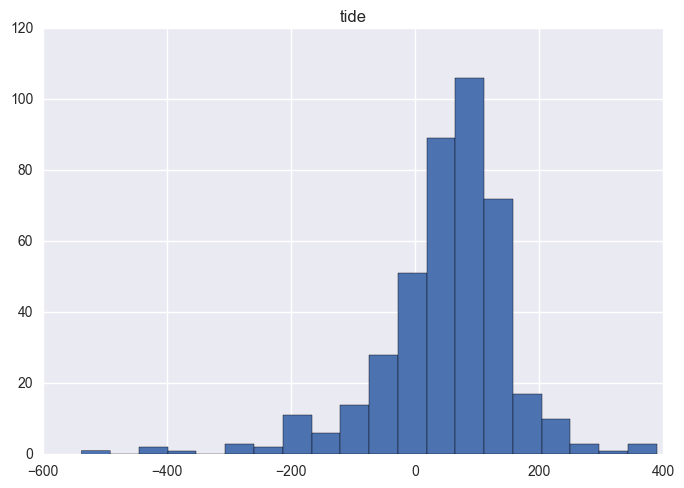

In [43]:
data_strongest_rise.hist(column='tide', bins=20)

In [43]:
data_strongest_rise.to_csv('data/dataviz/top_ten_landrise.csv')

#### Convert year to object to get rid of 1985.0

In [61]:
data_subset_viz['year'] = data_subset_viz['year'].astype(object)

data_subset_viz.dtypes

timestamp    datetime64[ns]
ID                    int64
tide                float64
location             object
latitude            float64
longitude           float64
country              object
year                 object
dtype: object

In [62]:
data_subset_viz = data_subset_viz.rename(columns={'ID': 'id'})

In [51]:
data_subset_viz_resampled = data_subset_viz_resampled.rename(columns={'ID': 'id'})

In [63]:
## Add continent data

data_subset_viz = data_subset_viz.merge(continents, left_on='country', right_on='iso3')

In [64]:
data_subset_viz_resampled['id'].nunique()

518

In [65]:
data_subset_viz = data_subset_viz.drop('iso3', 1)

In [66]:
data_subset_viz.to_csv('context_data/sealevel_viz_psmsl_1985_2015.csv', index=False)

#data_subset_viz.to_csv('data/dataviz/sealevel_viz_whole_timeseries.csv', index=False)

In [72]:
data_subset_viz_resampled.to_csv('data/dataviz/sealevel_viz_whole_timeseries.csv', index=False)

#data_subset_viz_resampled.to_csv('data/dataviz/sealevel_viz_psmsl_1985_2015.csv', index=False)

In [89]:
tidedata_series = (data_subset_viz.groupby(['ID'])
       .apply(lambda x: x[['year','tide']].to_dict('r'))
       .rename(columns={0:'tideData'}))
tidedata_series

ID
1       [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
3       [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
5       [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
7       [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
8       [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
9       [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
10      [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
11      [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
12      [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
14      [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
20      [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
22      [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
23      [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
24      [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
25      [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
32      [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
33      [{'year': 1985, 'tide': 0.0}, {'year': 1986, '...
41      [{'

In [90]:
cols = "ID location	latitude	longitude	country	continent".split()
j = data_subset_viz[cols].groupby("ID").first()
       #.to_json(orient='records', date_format='iso'))
j["tideData"] = tidedata_series
j = j.reset_index()
j = j.to_json(orient='records')

In [91]:
with open('data/dataviz/mapanimation.json', 'w') as fp:
    json.dump(json.loads(j), fp, indent=2, sort_keys=True)

print(json.dumps(json.loads(j), indent=2, sort_keys=True))

[
  {
    "ID": 1,
    "continent": "europe",
    "country": "FRA",
    "latitude": 48.383,
    "location": "Brest",
    "longitude": -4.495,
    "tideData": [
      {
        "tide": 0.0,
        "year": 1985
      },
      {
        "tide": -1.0,
        "year": 1986
      },
      {
        "tide": 4.0,
        "year": 1987
      },
      {
        "tide": 9.0,
        "year": 1988
      },
      {
        "tide": 15.0,
        "year": 1989
      },
      {
        "tide": 16.0,
        "year": 1990
      },
      {
        "tide": 15.0,
        "year": 1991
      },
      {
        "tide": 8.0,
        "year": 1992
      },
      {
        "tide": 5.0,
        "year": 1993
      },
      {
        "tide": 7.0,
        "year": 1994
      },
      {
        "tide": 13.0,
        "year": 1995
      },
      {
        "tide": 24.0,
        "year": 1996
      },
      {
        "tide": 35.0,
        "year": 1997
      },
      {
        "tide": 38.0,
        "year": 1998
      },
      